In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:28 - loss: 0.0100 - STD: 1.6707e-04 - MAE: 0.0741

 4/74 [>.............................] - ETA: 1s - loss: 0.0140 - STD: 2.2519e-04 - MAE: 0.0925  

 5/74 [=>............................] - ETA: 2s - loss: 0.0145 - STD: 2.5151e-04 - MAE: 0.0933

 6/74 [=>............................] - ETA: 2s - loss: 0.0149 - STD: 2.7633e-04 - MAE: 0.0938

 7/74 [=>............................] - ETA: 2s - loss: 0.0148 - STD: 3.0586e-04 - MAE: 0.0930

 8/74 [==>...........................] - ETA: 3s - loss: 0.0144 - STD: 3.3952e-04 - MAE: 0.0911

 9/74 [==>...........................] - ETA: 3s - loss: 0.0138 - STD: 3.7961e-04 - MAE: 0.0891

10/74 [===>..........................] - ETA: 3s - loss: 0.0134 - STD: 4.2403e-04 - MAE: 0.0880

11/74 [===>..........................] - ETA: 3s - loss: 0.0132 - STD: 4.6950e-04 - MAE: 0.0881

12/74 [===>..........................] - ETA: 3s - loss: 0.0131 - STD: 5.1367e-04 - MAE: 0.0886

13/74 [====>.........................] - ETA: 3s - loss: 0.0130 - STD: 5.5578e-04 - MAE: 0.0888

14/74 [====>.........................] - ETA: 3s - loss: 0.0128 - STD: 5.9261e-04 - MAE: 0.0885

15/74 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 6.2331e-04 - MAE: 0.0876

16/74 [=====>........................] - ETA: 3s - loss: 0.0123 - STD: 6.4984e-04 - MAE: 0.0868

17/74 [=====>........................] - ETA: 3s - loss: 0.0122 - STD: 6.7258e-04 - MAE: 0.0861

18/74 [======>.......................] - ETA: 3s - loss: 0.0121 - STD: 6.9245e-04 - MAE: 0.0854

19/74 [======>.......................] - ETA: 3s - loss: 0.0120 - STD: 7.1211e-04 - MAE: 0.0848

20/74 [=======>......................] - ETA: 2s - loss: 0.0119 - STD: 7.3259e-04 - MAE: 0.0843

21/74 [=======>......................] - ETA: 2s - loss: 0.0118 - STD: 7.5564e-04 - MAE: 0.0838

22/74 [=======>......................] - ETA: 2s - loss: 0.0117 - STD: 7.8010e-04 - MAE: 0.0833

23/74 [========>.....................] - ETA: 2s - loss: 0.0115 - STD: 8.0728e-04 - MAE: 0.0829

24/74 [========>.....................] - ETA: 2s - loss: 0.0115 - STD: 8.3769e-04 - MAE: 0.0826

25/74 [=========>....................] - ETA: 2s - loss: 0.0114 - STD: 8.7006e-04 - MAE: 0.0824

26/74 [=========>....................] - ETA: 2s - loss: 0.0113 - STD: 9.0319e-04 - MAE: 0.0823

27/74 [=========>....................] - ETA: 2s - loss: 0.0112 - STD: 9.3706e-04 - MAE: 0.0823

28/74 [==========>...................] - ETA: 2s - loss: 0.0112 - STD: 9.7074e-04 - MAE: 0.0822

29/74 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 0.0010 - MAE: 0.0820    

30/74 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 0.0010 - MAE: 0.0818

31/74 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 0.0011 - MAE: 0.0816

32/74 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 0.0011 - MAE: 0.0814

33/74 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 0.0011 - MAE: 0.0811

34/74 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0012 - MAE: 0.0809

35/74 [=============>................] - ETA: 2s - loss: 0.0108 - STD: 0.0012 - MAE: 0.0807

36/74 [=============>................] - ETA: 2s - loss: 0.0107 - STD: 0.0012 - MAE: 0.0805

37/74 [==============>...............] - ETA: 2s - loss: 0.0107 - STD: 0.0013 - MAE: 0.0803

38/74 [==============>...............] - ETA: 2s - loss: 0.0107 - STD: 0.0013 - MAE: 0.0802

39/74 [==============>...............] - ETA: 2s - loss: 0.0106 - STD: 0.0013 - MAE: 0.0801

40/74 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 0.0014 - MAE: 0.0800

41/74 [===============>..............] - ETA: 1s - loss: 0.0105 - STD: 0.0014 - MAE: 0.0799

42/74 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0798

43/74 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.0015 - MAE: 0.0797

44/74 [================>.............] - ETA: 1s - loss: 0.0104 - STD: 0.0016 - MAE: 0.0796

45/74 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.0017 - MAE: 0.0794

46/74 [=================>............] - ETA: 1s - loss: 0.0104 - STD: 0.0017 - MAE: 0.0793

47/74 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0018 - MAE: 0.0792

48/74 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0018 - MAE: 0.0790

49/74 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0019 - MAE: 0.0789

50/74 [===================>..........] - ETA: 1s - loss: 0.0102 - STD: 0.0020 - MAE: 0.0788

51/74 [===================>..........] - ETA: 1s - loss: 0.0102 - STD: 0.0021 - MAE: 0.0787

52/74 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.0022 - MAE: 0.0786

53/74 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 0.0022 - MAE: 0.0785

54/74 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 0.0023 - MAE: 0.0784

55/74 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.0025 - MAE: 0.0784

56/74 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.0026 - MAE: 0.0783

57/74 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0027 - MAE: 0.0782

58/74 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0028 - MAE: 0.0781

59/74 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0030 - MAE: 0.0780

60/74 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0031 - MAE: 0.0779

61/74 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 0.0032 - MAE: 0.0778

62/74 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0034 - MAE: 0.0777

63/74 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0036 - MAE: 0.0776

64/74 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0038 - MAE: 0.0775

65/74 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0040 - MAE: 0.0774

66/74 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0042 - MAE: 0.0773

67/74 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0044 - MAE: 0.0772

68/74 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0047 - MAE: 0.0771

69/74 [==========================>...] - ETA: 0s - loss: 0.0097 - STD: 0.0050 - MAE: 0.0770

70/74 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0052 - MAE: 0.0769

71/74 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0055 - MAE: 0.0768

74/74 [==============================] - 6s 72ms/step - loss: 0.0096 - STD: 0.0065 - MAE: 0.0765 - val_loss: 0.0069 - val_STD: 0.0220 - val_MAE: 0.0644


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0075 - STD: 0.0334 - MAE: 0.0690

 2/74 [..............................] - ETA: 4s - loss: 0.0075 - STD: 0.0343 - MAE: 0.0692

 3/74 [>.............................] - ETA: 4s - loss: 0.0074 - STD: 0.0351 - MAE: 0.0687

 4/74 [>.............................] - ETA: 4s - loss: 0.0074 - STD: 0.0358 - MAE: 0.0686

 5/74 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.0364 - MAE: 0.0683

 6/74 [=>............................] - ETA: 3s - loss: 0.0074 - STD: 0.0371 - MAE: 0.0683

 7/74 [=>............................] - ETA: 3s - loss: 0.0074 - STD: 0.0378 - MAE: 0.0682

 8/74 [==>...........................] - ETA: 3s - loss: 0.0074 - STD: 0.0384 - MAE: 0.0681

 9/74 [==>...........................] - ETA: 3s - loss: 0.0074 - STD: 0.0389 - MAE: 0.0681

10/74 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.0394 - MAE: 0.0680

11/74 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.0398 - MAE: 0.0679

12/74 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.0402 - MAE: 0.0678

13/74 [====>.........................] - ETA: 3s - loss: 0.0073 - STD: 0.0404 - MAE: 0.0677

14/74 [====>.........................] - ETA: 3s - loss: 0.0073 - STD: 0.0407 - MAE: 0.0676

15/74 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0409 - MAE: 0.0675

16/74 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0410 - MAE: 0.0674

17/74 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0411 - MAE: 0.0673

18/74 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0412 - MAE: 0.0672

19/74 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0671

20/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0671

21/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0670

22/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0669

23/74 [========>.....................] - ETA: 2s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0669

24/74 [========>.....................] - ETA: 2s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0668

25/74 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0413 - MAE: 0.0666

26/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0413 - MAE: 0.0666

27/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0413 - MAE: 0.0665

28/74 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0665

29/74 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0664

30/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0415 - MAE: 0.0664

31/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0416 - MAE: 0.0663

32/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0417 - MAE: 0.0662

33/74 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0417 - MAE: 0.0662

34/74 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0418 - MAE: 0.0661

35/74 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0420 - MAE: 0.0661

36/74 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0421 - MAE: 0.0661

37/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0422 - MAE: 0.0660

38/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0423 - MAE: 0.0660

39/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0424 - MAE: 0.0660

40/74 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0425 - MAE: 0.0659

41/74 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0426 - MAE: 0.0659

42/74 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0427 - MAE: 0.0659

43/74 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0428 - MAE: 0.0658

44/74 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0429 - MAE: 0.0658

45/74 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0430 - MAE: 0.0657

47/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0431 - MAE: 0.0656

48/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0432 - MAE: 0.0656

49/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0433 - MAE: 0.0655

50/74 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0433 - MAE: 0.0655

51/74 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0434 - MAE: 0.0654

52/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0435 - MAE: 0.0654

53/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0435 - MAE: 0.0654

54/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0436 - MAE: 0.0653

55/74 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0437 - MAE: 0.0652

56/74 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0437 - MAE: 0.0652

57/74 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0438 - MAE: 0.0652

58/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0439 - MAE: 0.0651

59/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0440 - MAE: 0.0650

60/74 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0440 - MAE: 0.0650

61/74 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0441 - MAE: 0.0649

62/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0442 - MAE: 0.0649

63/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0443 - MAE: 0.0648

64/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0443 - MAE: 0.0647

65/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0444 - MAE: 0.0647

66/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0445 - MAE: 0.0646

67/74 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0446 - MAE: 0.0645

68/74 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0447 - MAE: 0.0645

69/74 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0448 - MAE: 0.0644

70/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0448 - MAE: 0.0643

71/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0449 - MAE: 0.0642

72/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0450 - MAE: 0.0642

73/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0451 - MAE: 0.0641

74/74 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0452 - MAE: 0.0640

74/74 [==============================] - 5s 62ms/step - loss: 0.0068 - STD: 0.0452 - MAE: 0.0640 - val_loss: 0.0052 - val_STD: 0.0380 - val_MAE: 0.0545


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0059 - STD: 0.0553 - MAE: 0.0599

 2/74 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0537 - MAE: 0.0586

 3/74 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0549 - MAE: 0.0588

 4/74 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.0546 - MAE: 0.0582

 5/74 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0579

 6/74 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0581

 7/74 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0550 - MAE: 0.0580

 8/74 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0556 - MAE: 0.0581

 9/74 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0559 - MAE: 0.0580

10/74 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0559 - MAE: 0.0578

11/74 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0563 - MAE: 0.0579

12/74 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0565 - MAE: 0.0577

13/74 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0567 - MAE: 0.0575

14/74 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0570 - MAE: 0.0576

15/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0571 - MAE: 0.0575

16/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0576

17/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0575

18/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0574

19/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0575

20/74 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0574

21/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0581 - MAE: 0.0573

22/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0582 - MAE: 0.0572

23/74 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0582 - MAE: 0.0572

24/74 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0583 - MAE: 0.0571

25/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0584 - MAE: 0.0571

26/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0584 - MAE: 0.0570

27/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0585 - MAE: 0.0569

28/74 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0569

29/74 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0568

30/74 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0568

31/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0587 - MAE: 0.0567

32/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0588 - MAE: 0.0567

33/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0589 - MAE: 0.0566

34/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0588 - MAE: 0.0565

35/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0566

36/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0565

37/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0565

38/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0565

39/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0564

40/74 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0564

41/74 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0563

42/74 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0563

43/74 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0563

44/74 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0593 - MAE: 0.0562

45/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0593 - MAE: 0.0562

46/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0593 - MAE: 0.0561

47/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0561

48/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0560

49/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0560

50/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0595 - MAE: 0.0560

51/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0595 - MAE: 0.0559

52/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0559

53/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0558

54/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0558

55/74 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0557

56/74 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0557

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0556

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0555

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0601 - MAE: 0.0555

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0601 - MAE: 0.0555

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0601 - MAE: 0.0554

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0602 - MAE: 0.0554

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0602 - MAE: 0.0553

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0603 - MAE: 0.0553

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0603 - MAE: 0.0553

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0554

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0554

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0553

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0553

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0553

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0553

73/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0554

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0555

74/74 [==============================] - 5s 62ms/step - loss: 0.0053 - STD: 0.0605 - MAE: 0.0555 - val_loss: 0.0048 - val_STD: 0.0433 - val_MAE: 0.0499


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0051 - STD: 0.0567 - MAE: 0.0520

 2/74 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0654 - MAE: 0.0619

 3/74 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0594

 4/74 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.0571 - MAE: 0.0585

 5/74 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0581

 6/74 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0593

 8/74 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0581

 9/74 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0576

10/74 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0586

11/74 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0581

12/74 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0563 - MAE: 0.0579

13/74 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0559 - MAE: 0.0575

14/74 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0563 - MAE: 0.0577

15/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0567 - MAE: 0.0578

16/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0564 - MAE: 0.0576

17/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0561 - MAE: 0.0573

18/74 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0561 - MAE: 0.0571

19/74 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0565 - MAE: 0.0571

20/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0567 - MAE: 0.0570

21/74 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0568

22/74 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0565 - MAE: 0.0566

23/74 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0565

24/74 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0566

25/74 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0572 - MAE: 0.0564

26/74 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0562

27/74 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0561

28/74 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0561

29/74 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0560

30/74 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0559

31/74 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0558

32/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0557

33/74 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0556

34/74 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0555

35/74 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0554

36/74 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0553

37/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0553

38/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0552

39/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0551

40/74 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0550

41/74 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0549

42/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0548

43/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0547

44/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0547

45/74 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0546

46/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0545

47/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0545

48/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0544

49/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0543

50/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0543

51/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0542

52/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0542

53/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0541

54/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0540

55/74 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0540

56/74 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0539

57/74 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0539

58/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0538

59/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0538

60/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0537

61/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0537

62/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0536

63/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0536

64/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0536

65/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0535

66/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0535

67/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0534

68/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0534

69/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0533

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0625 - MAE: 0.0533

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0533

72/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0532

73/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0532

74/74 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0532

74/74 [==============================] - 5s 63ms/step - loss: 0.0049 - STD: 0.0627 - MAE: 0.0532 - val_loss: 0.0043 - val_STD: 0.0509 - val_MAE: 0.0474


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0503

 2/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0513

 3/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0509

 5/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0508

 6/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0507

 7/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0504

 8/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0505

 9/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0503

10/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0503

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0504

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0503

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0502

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0503

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0503

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0503

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0504

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0503

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0503

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0504

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0503

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0503

23/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0503

24/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0502

25/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0503

26/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

27/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0502

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0503

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

40/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

41/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

42/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0501

43/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0501

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0501

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0499

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

74/74 [==============================] - 5s 63ms/step - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500 - val_loss: 0.0038 - val_STD: 0.0572 - val_MAE: 0.0465


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0500

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0498

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0493

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0500

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0496

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0494

 7/74 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0500

 8/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

 9/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0504

10/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0503

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0498

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0499

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0497

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0497

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0496

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0496

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0496

22/74 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0495

23/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0495

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0494

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0494

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0494

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0494

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0494

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0493

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0493

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0493

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0492

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0492

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0492

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0490

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0493

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0492

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0490

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490

74/74 [==============================] - 5s 62ms/step - loss: 0.0043 - STD: 0.0692 - MAE: 0.0490 - val_loss: 0.0038 - val_STD: 0.0547 - val_MAE: 0.0449


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0482

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0487

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0484

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0493

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0491

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0491

 7/74 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0488

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0487

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0487

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0485

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0485

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0484

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0486

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0485

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0484

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0483

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0485

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0486

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0486

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0489

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0490

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0490

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0491

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0495

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0495

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0499

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0503

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0504

35/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0512

36/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0680 - MAE: 0.0514

37/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0672 - MAE: 0.0517

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0670 - MAE: 0.0517

39/74 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0524

40/74 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0525

41/74 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0528

42/74 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0528

43/74 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0531

44/74 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0535

45/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0646 - MAE: 0.0535

46/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0536

47/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0537

48/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0537

49/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0540

50/74 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0541

51/74 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0541

52/74 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0541

53/74 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0541

54/74 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0541

55/74 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0542

56/74 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0542

57/74 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0542

58/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0542

59/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0541

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0541

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0541

62/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0541

63/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0540

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0540

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0540

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0616 - MAE: 0.0540

67/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0616 - MAE: 0.0539

68/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0538

69/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0538

70/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0616 - MAE: 0.0537

71/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0537

72/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0536

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0536

74/74 [==============================] - 5s 62ms/step - loss: 0.0050 - STD: 0.0618 - MAE: 0.0535 - val_loss: 0.0037 - val_STD: 0.0557 - val_MAE: 0.0460


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0505

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0495

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0491

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0490

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0491

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0491

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0491

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0490

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0490

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0489

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0488

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0488

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0486

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

22/74 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0485

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0485

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0485

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0485

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0485

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0485

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0484

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

39/74 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

41/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

43/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

57/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

74/74 [==============================] - 5s 61ms/step - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478 - val_loss: 0.0036 - val_STD: 0.0581 - val_MAE: 0.0442


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0471

 2/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

 5/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0472

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0471

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0471

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

43/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0476

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0476

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0485

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0484

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0485

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0484

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0486

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0487

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0488

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0488

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0488

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0488

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0489

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

74/74 [==============================] - 5s 62ms/step - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487 - val_loss: 0.0035 - val_STD: 0.0612 - val_MAE: 0.0452


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0502

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0483

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0480

 6/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0478

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0478

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0476

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0475

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0474

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0474

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0474

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

74/74 [==============================] - 5s 62ms/step - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468 - val_loss: 0.0037 - val_STD: 0.0567 - val_MAE: 0.0437


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0683 - MAE: 0.0463

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0705 - MAE: 0.0459

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

 4/74 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0464

 5/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0465

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0466

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

21/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

22/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

39/74 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

74/74 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464 - val_loss: 0.0035 - val_STD: 0.0594 - val_MAE: 0.0430


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0452

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0459

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0455

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0458

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0458

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

23/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

74/74 [==============================] - 5s 62ms/step - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459 - val_loss: 0.0034 - val_STD: 0.0663 - val_MAE: 0.0447


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0483

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0473

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0470

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0466

 5/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0463

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0467

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0466

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0468

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0466

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0465

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0464

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0462

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0462

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0462

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0462

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0462

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0462

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0460

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

74/74 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461 - val_loss: 0.0034 - val_STD: 0.0572 - val_MAE: 0.0425


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0449

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0451

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0459

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0697 - MAE: 0.0458

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0707 - MAE: 0.0460

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0461

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0707 - MAE: 0.0459

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0459

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0459

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0459

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0458

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0457

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0457

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0457

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0457

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

74/74 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455 - val_loss: 0.0032 - val_STD: 0.0641 - val_MAE: 0.0429


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0467

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0451

 3/74 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

 4/74 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0452

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

21/74 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

22/74 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0458

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

39/74 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

74/74 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454 - val_loss: 0.0032 - val_STD: 0.0637 - val_MAE: 0.0420


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0443

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0441

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

38/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

39/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

74/74 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449 - val_loss: 0.0031 - val_STD: 0.0641 - val_MAE: 0.0419


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0449

 2/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0448

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0447

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0446

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0448

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0447

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

74/74 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447 - val_loss: 0.0031 - val_STD: 0.0652 - val_MAE: 0.0420


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0450

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0446

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0449

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0450

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

74/74 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443 - val_loss: 0.0031 - val_STD: 0.0649 - val_MAE: 0.0413


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0442

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0442

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0443

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0448

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0447

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

74/74 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444 - val_loss: 0.0042 - val_STD: 0.0531 - val_MAE: 0.0464


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0642 - MAE: 0.0467

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0458

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0713 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0453

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0451

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0446

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0444

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0442

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0442

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0442

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0441

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0440

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455

74/74 [==============================] - 5s 61ms/step - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455 - val_loss: 0.0071 - val_STD: 0.0393 - val_MAE: 0.0620


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0071 - STD: 0.0481 - MAE: 0.0611

 2/74 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.0460 - MAE: 0.0619

 3/74 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0538 - MAE: 0.0578

 4/74 [>.............................] - ETA: 4s - loss: 0.0066 - STD: 0.0602 - MAE: 0.0621

 5/74 [=>............................] - ETA: 4s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0602

 6/74 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.0547 - MAE: 0.0607

 7/74 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0590

 8/74 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0562 - MAE: 0.0601

 9/74 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0572 - MAE: 0.0599

10/74 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0588

11/74 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0550 - MAE: 0.0585

12/74 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0543 - MAE: 0.0578

13/74 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0549 - MAE: 0.0576

14/74 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0558 - MAE: 0.0581

15/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0560 - MAE: 0.0576

16/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0555 - MAE: 0.0572

17/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0569

18/74 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0550 - MAE: 0.0564

19/74 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0555 - MAE: 0.0563

20/74 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0560 - MAE: 0.0563

21/74 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0562 - MAE: 0.0559

22/74 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0560 - MAE: 0.0557

23/74 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0559 - MAE: 0.0554

24/74 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0561 - MAE: 0.0551

25/74 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0566 - MAE: 0.0549

26/74 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0570 - MAE: 0.0547

27/74 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0572 - MAE: 0.0545

28/74 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0573 - MAE: 0.0542

29/74 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0575 - MAE: 0.0540

30/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0580 - MAE: 0.0538

31/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0584 - MAE: 0.0536

32/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0587 - MAE: 0.0534

33/74 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0589 - MAE: 0.0532

34/74 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0592 - MAE: 0.0530

35/74 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0597 - MAE: 0.0528

36/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0601 - MAE: 0.0526

37/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0603 - MAE: 0.0524

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0606 - MAE: 0.0522

39/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0609 - MAE: 0.0521

40/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0613 - MAE: 0.0519

41/74 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0616 - MAE: 0.0518

42/74 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0618 - MAE: 0.0516

43/74 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0621 - MAE: 0.0514

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0625 - MAE: 0.0513

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0627 - MAE: 0.0512

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0629 - MAE: 0.0510

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0631 - MAE: 0.0509

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0634 - MAE: 0.0508

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0636 - MAE: 0.0506

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0637 - MAE: 0.0505

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0639 - MAE: 0.0504

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0641 - MAE: 0.0503

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0643 - MAE: 0.0502

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0644 - MAE: 0.0501

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0646 - MAE: 0.0500

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0648 - MAE: 0.0499

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0649 - MAE: 0.0498

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0497

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0496

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0653 - MAE: 0.0495

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0655 - MAE: 0.0494

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0656 - MAE: 0.0493

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0492

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0661 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0489

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0664 - MAE: 0.0488

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0665 - MAE: 0.0487

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0666 - MAE: 0.0486

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0668 - MAE: 0.0486

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0485

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0484

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0671 - MAE: 0.0484

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0671 - MAE: 0.0484 - val_loss: 0.0031 - val_STD: 0.0637 - val_MAE: 0.0410


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0443

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

 3/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

 4/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0438

 5/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

39/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

74/74 [==============================] - 4s 60ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0621 - val_MAE: 0.0404


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0431

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431 - val_loss: 0.0038 - val_STD: 0.0565 - val_MAE: 0.0438


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0447

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0442

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0447

 4/74 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0447

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0449

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0456

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0472

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0726 - MAE: 0.0477

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0479

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0719 - MAE: 0.0486

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0486

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0484

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0487

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0485

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0485

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0483

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0484

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0483

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0482

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0483

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0481

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0480

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0480

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0478

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0476

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0477

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0476

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0475

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0471

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0471

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0470

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0469

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0467

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0466

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0464

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0463

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0462

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0462

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0462

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0461

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0461

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0460

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0459

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0459

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0456

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0456

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0456

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0455

74/74 [==============================] - 5s 61ms/step - loss: 0.0037 - STD: 0.0723 - MAE: 0.0455 - val_loss: 0.0030 - val_STD: 0.0646 - val_MAE: 0.0404


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0436

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0430

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

21/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0429

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0430

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0431

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0432

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0432

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

74/74 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431 - val_loss: 0.0030 - val_STD: 0.0634 - val_MAE: 0.0400


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0432

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0428

 3/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0399


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0424

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0426

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0641 - val_MAE: 0.0398


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0427

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

 4/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

21/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0428

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0658 - val_MAE: 0.0403


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0434

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0428

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

21/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427 - val_loss: 0.0029 - val_STD: 0.0628 - val_MAE: 0.0396


Epoch 30/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

20/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

21/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

38/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

39/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - 4s 59ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0624 - val_MAE: 0.0396


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0423

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

 4/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0420

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0429

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0431

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0431

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0431

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427 - val_loss: 0.0030 - val_STD: 0.0639 - val_MAE: 0.0395


Epoch 32/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

 2/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0418

 4/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

39/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - 4s 59ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422 - val_loss: 0.0032 - val_STD: 0.0600 - val_MAE: 0.0401


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0731 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0418

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423 - val_loss: 0.0034 - val_STD: 0.0583 - val_MAE: 0.0412


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0423

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0420

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0419

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0419

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0417

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - 4s 60ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0391


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0417

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 4/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0415

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

39/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

74/74 [==============================] - 4s 57ms/step - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0627 - val_MAE: 0.0393


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0410

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0416

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0417

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418 - val_loss: 0.0033 - val_STD: 0.0587 - val_MAE: 0.0408


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0425

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0422

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0421

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0390


Epoch 38/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0751 - MAE: 0.0413

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0420

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0420

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0627 - val_MAE: 0.0390


Epoch 39/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0411

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0411

 4/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0411

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0668 - val_MAE: 0.0402


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0422

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0796 - MAE: 0.0416

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0639 - val_MAE: 0.0389


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 2/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0407

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0407

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0415

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0662 - val_MAE: 0.0396


Epoch 42/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0415

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

21/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0030 - val_STD: 0.0683 - val_MAE: 0.0415


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0827 - MAE: 0.0438

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0427

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0424

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0423

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0420

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0399


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0421

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0412

 3/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0409

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0409

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

19/74 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

20/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

21/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

37/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

38/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - 4s 57ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0650 - val_MAE: 0.0387


Epoch 45/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0403

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/74 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409 - val_loss: 0.0029 - val_STD: 0.0655 - val_MAE: 0.0388


Epoch 46/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0405

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

74/74 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0608 - val_MAE: 0.0391


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

 3/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0406

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

20/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

21/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - 4s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0397


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0814 - MAE: 0.0429

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0414

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0612 - val_MAE: 0.0387


Epoch 49/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0418

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0414

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0760 - MAE: 0.0412

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0411

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0383


Epoch 50/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0410

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0413

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0411

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411 - val_loss: 0.0028 - val_STD: 0.0650 - val_MAE: 0.0390


Epoch 51/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0409

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0407

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0030 - val_STD: 0.0619 - val_MAE: 0.0390


Epoch 52/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0405

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0642 - val_MAE: 0.0384


Epoch 53/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0392

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0397

 4/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0396

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0398

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0398

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0399

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

21/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0382


Epoch 54/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0396

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0395

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0404

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0634 - val_MAE: 0.0385


Epoch 55/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0393

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0408

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402 - val_loss: 0.0041 - val_STD: 0.0552 - val_MAE: 0.0449


Epoch 56/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0444

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0424

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0665 - val_MAE: 0.0386


Epoch 57/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0400

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0402

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0410

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0414

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401 - val_loss: 0.0030 - val_STD: 0.0620 - val_MAE: 0.0386


Epoch 58/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0394

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0768 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0395

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

74/74 [==============================] - 4s 59ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0662 - val_MAE: 0.0382


Epoch 59/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0807 - MAE: 0.0393

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0816 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0808 - MAE: 0.0395

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0397

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0396

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0802 - MAE: 0.0398

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0398

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0398

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0398

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0398

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0399

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0399

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0399

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

74/74 [==============================] - 4s 60ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0669 - val_MAE: 0.0391


Epoch 60/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0405

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0399

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0381


Epoch 61/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0393

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0396

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396 - val_loss: 0.0029 - val_STD: 0.0632 - val_MAE: 0.0383


Epoch 62/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0772 - MAE: 0.0392

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0401

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

20/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

21/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0399

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

39/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

74/74 [==============================] - 4s 60ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397 - val_loss: 0.0037 - val_STD: 0.0583 - val_MAE: 0.0426


Epoch 63/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0423

 2/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0406

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0400

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0379


Epoch 64/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0399

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0680 - val_MAE: 0.0392


Epoch 65/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0410

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0395

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0029 - val_STD: 0.0639 - val_MAE: 0.0384


Epoch 66/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0771 - MAE: 0.0386

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0385

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0385

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0386

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0388

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0663 - val_MAE: 0.0383


Epoch 67/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0772 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0392

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0629 - val_MAE: 0.0382


Epoch 68/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0388

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0391

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0032 - val_STD: 0.0600 - val_MAE: 0.0397


Epoch 69/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0722 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0765 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0768 - MAE: 0.0397

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0772 - MAE: 0.0394

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0391

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

74/74 [==============================] - 4s 60ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390 - val_loss: 0.0028 - val_STD: 0.0655 - val_MAE: 0.0379


Epoch 70/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

 2/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0818 - MAE: 0.0387

 3/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0391

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0398

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0651 - val_MAE: 0.0379


Epoch 71/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0786 - MAE: 0.0383

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0814 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0695 - val_MAE: 0.0394


Epoch 72/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0832 - MAE: 0.0409

 2/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

 3/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

 4/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0398

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0666 - val_MAE: 0.0378


Epoch 73/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0393

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0389

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0377


Epoch 74/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0391

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0390

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0393

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0393

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0658 - val_MAE: 0.0379


Epoch 75/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0390

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390 - val_loss: 0.0028 - val_STD: 0.0697 - val_MAE: 0.0393


Epoch 76/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0836 - MAE: 0.0407

 2/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0396

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0387

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

74/74 [==============================] - 4s 60ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390 - val_loss: 0.0027 - val_STD: 0.0681 - val_MAE: 0.0380


Epoch 77/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0391

 2/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0388

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0385

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0390

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0672 - val_MAE: 0.0381


Epoch 78/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0381

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0785 - MAE: 0.0381

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0388

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0388

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0387

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0386

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

19/74 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

20/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

21/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

38/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

74/74 [==============================] - 4s 57ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0683 - val_MAE: 0.0388


Epoch 79/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0393

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0776 - MAE: 0.0388

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0778 - MAE: 0.0389

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0387

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0779 - MAE: 0.0386

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0386

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0385

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0384

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

21/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

74/74 [==============================] - 4s 60ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0378


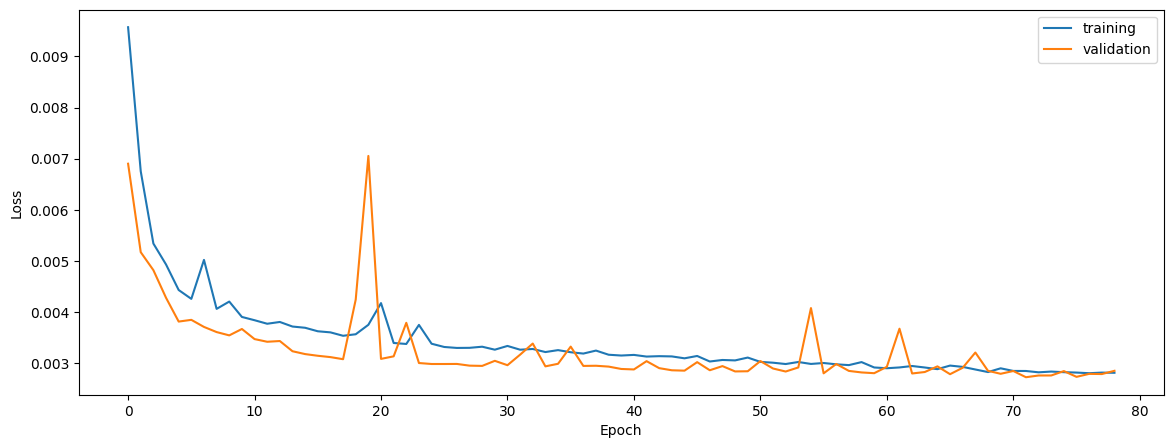

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


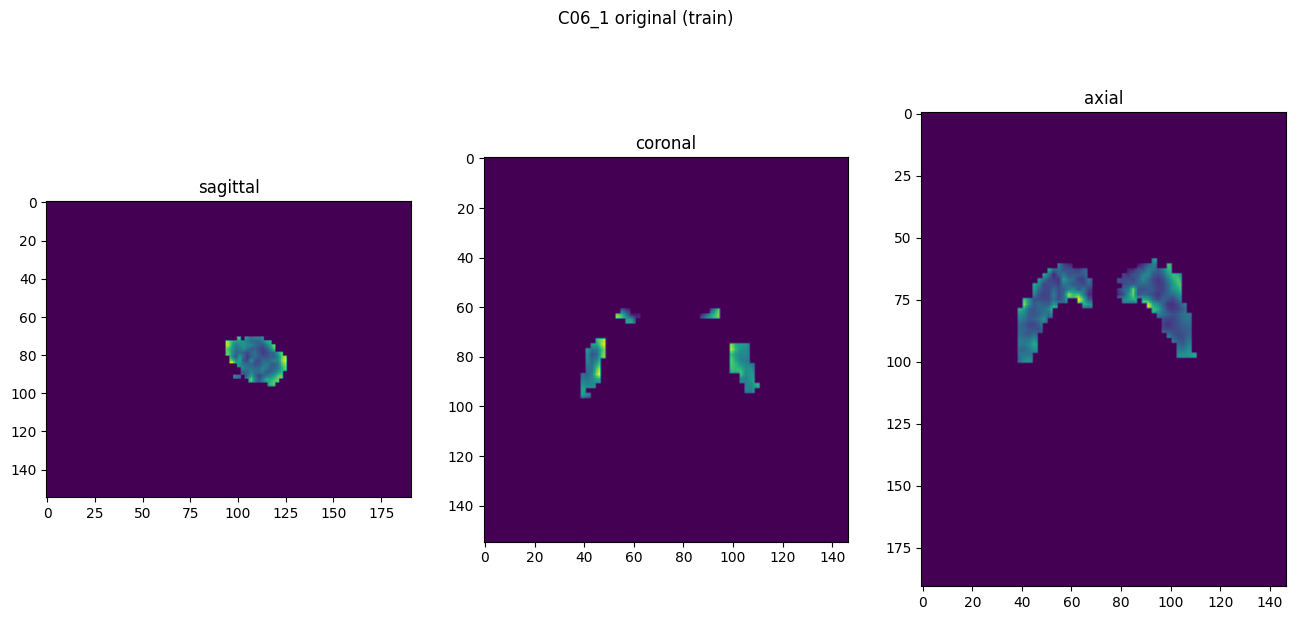

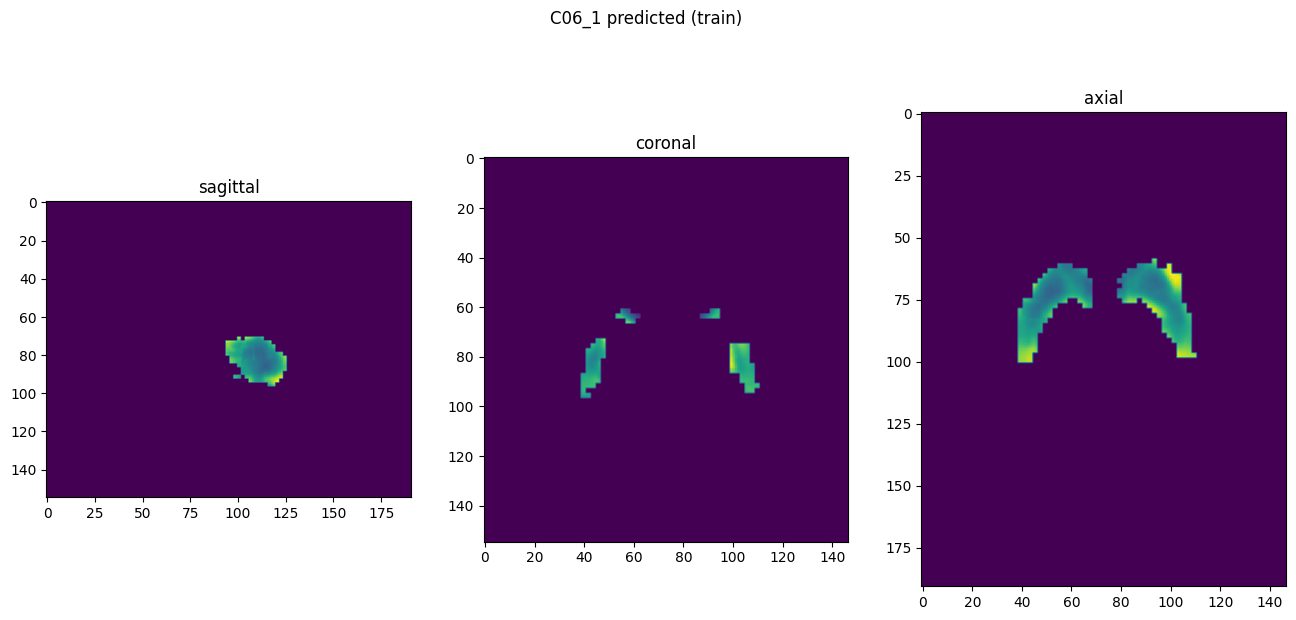

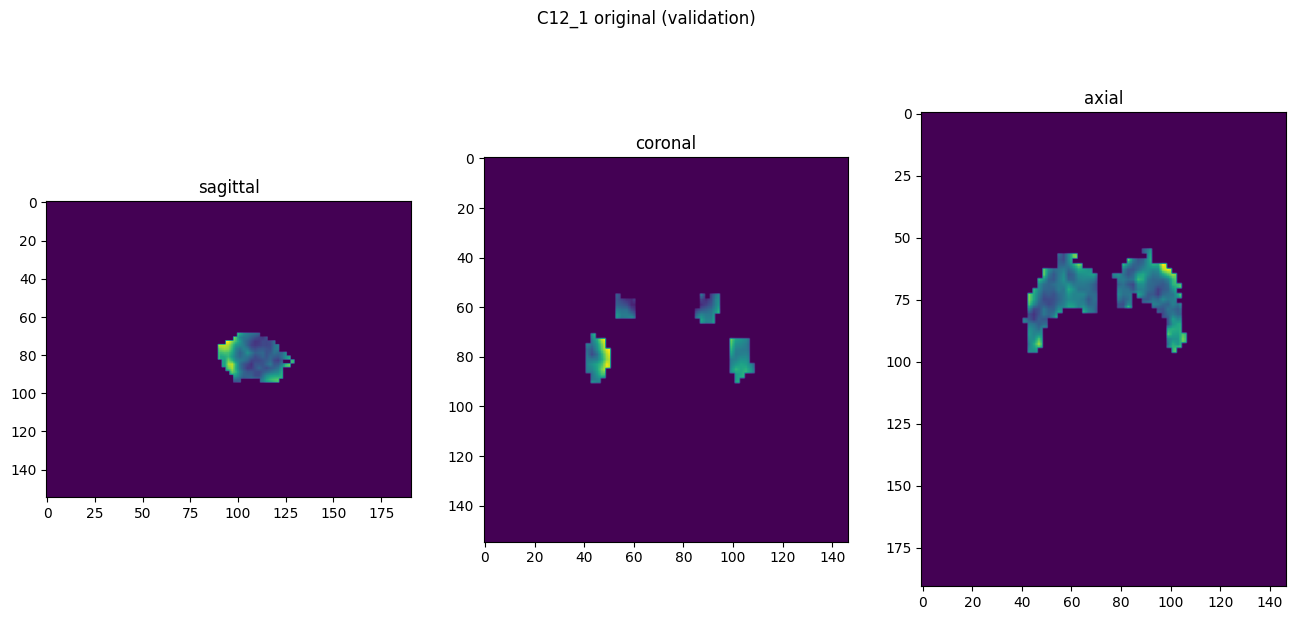

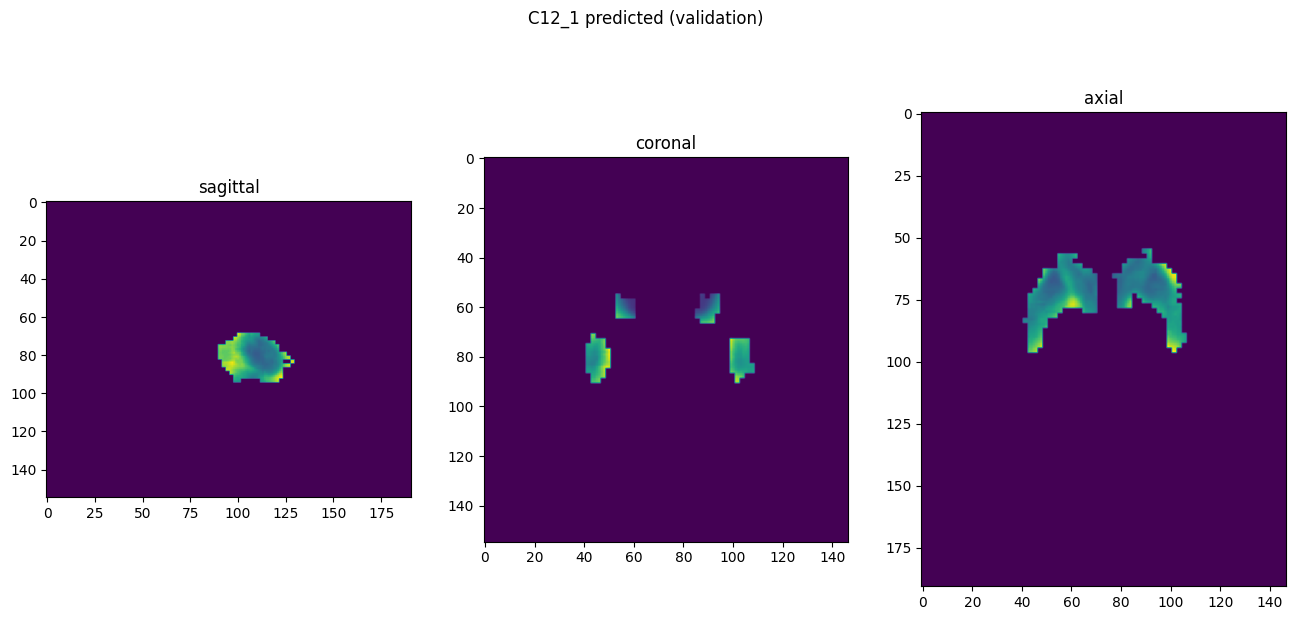

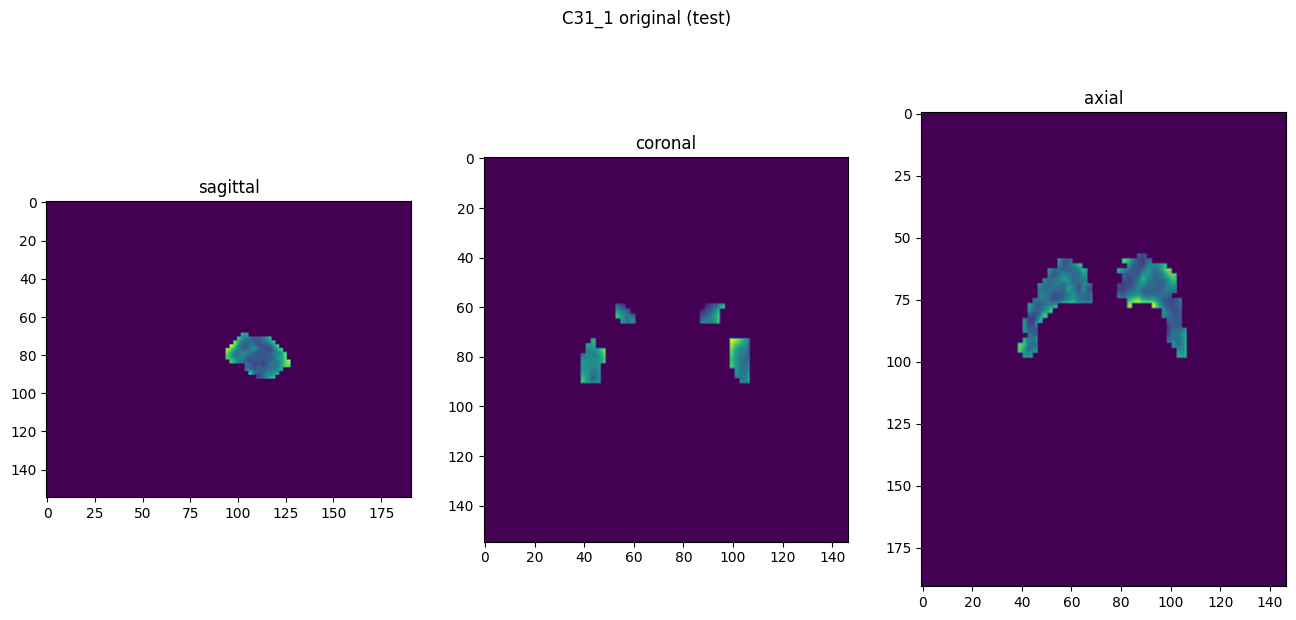

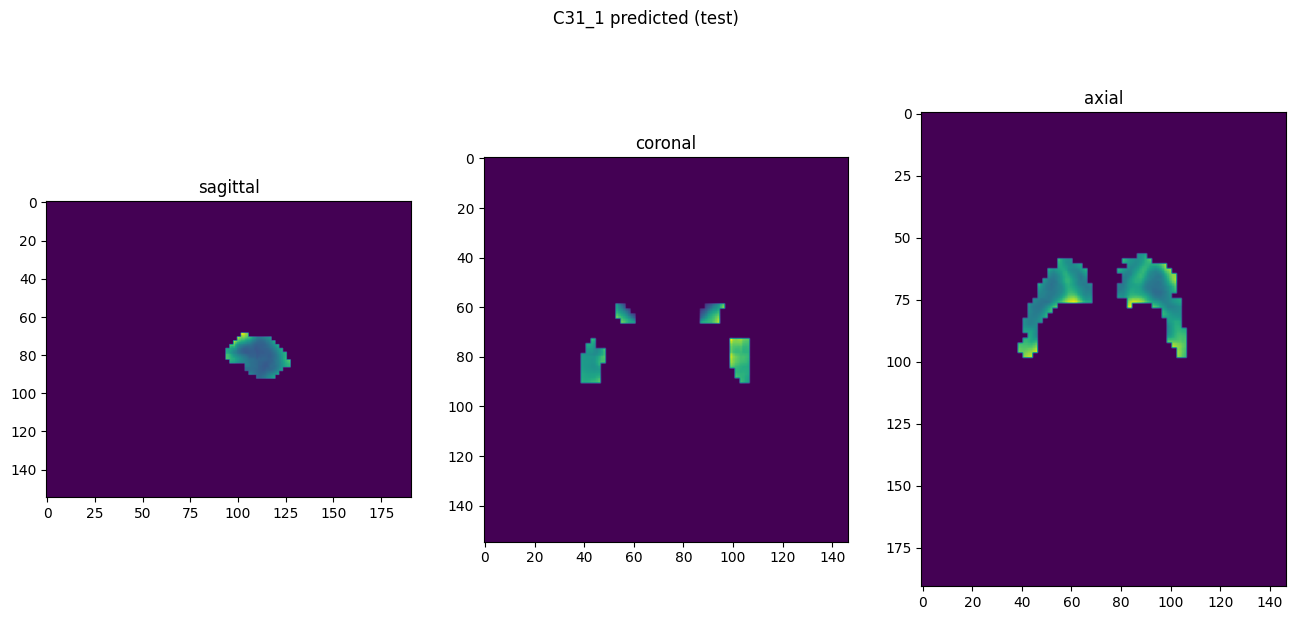

In [10]:
showResults(model, gen, threshold=None, background=False)